# Optimization WFA - Logistic Regression

## Logistic Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades

In [3]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
plt.style.use("seaborn-v0_8")

In [5]:
from backtesting import Strategy

In [6]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [7]:
XAUUSD = load_data()

In [8]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [9]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


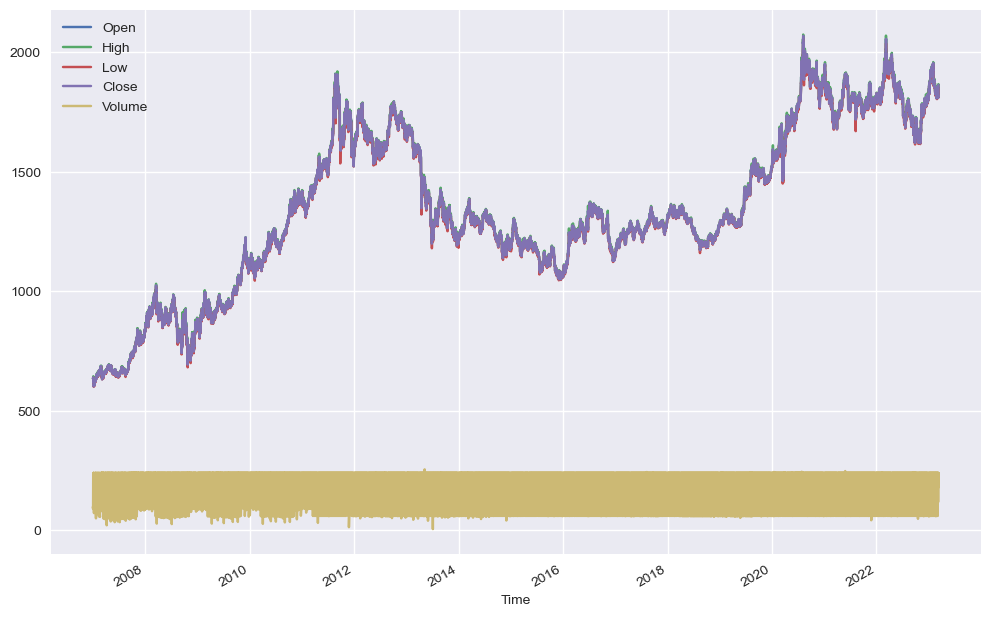

In [10]:
XAUUSD['H4'].plot(figsize=(12, 8))
plt.show()

## ML

### Class and Strategy ML

In [8]:
class Logistic_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [9]:
mainFolder = 'Machine_Learning'
strategy = Logistic_Regression
strategyName = 'Logistic_Regressionon'
account_size = 1000
folder_ML_Strategy = 'Logistic Regression'
subFolder = 'Optimization'

In [10]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data['returns_signal'] = data['returns'].shift(-1)
        data["direction"] = np.sign(data.returns_signal)
        data.dropna(inplace=True)
        cols = []
        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size  :i ]

            lm = LogisticRegression(C=1e6, max_iter=100000, multi_class="ovr")
            lm.fit(rolling_window_data[cols], rolling_window_data['direction'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i]).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100)
        result = backtest.run()
        return result

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [40]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'D1'

### Window size 1 year

In [41]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [42]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [43]:
test = ml.Run()

In [44]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   94.976172
Equity Final [$]                     1716.775
Equity Peak [$]                      2172.282
Return [%]                            71.6775
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    2.741284
Volatility (Ann.) [%]               15.692632
Sharpe Ratio                         0.174686
Sortino Ratio                        0.253934
Calmar Ratio                         0.053922
Max. Drawdown [%]                  -50.837838
Avg. Drawdown [%]                    -4.95643
Max. Drawdown Duration     2661 days 00:00:00
Avg. Drawdown Duration      127 days 00:00:00
# Trades                                 1786
Win Rate [%]                        51.511758
Best Trade [%]                       14.80012
Worst Trade [%]                    -14.044277
Avg. Trade [%]                    

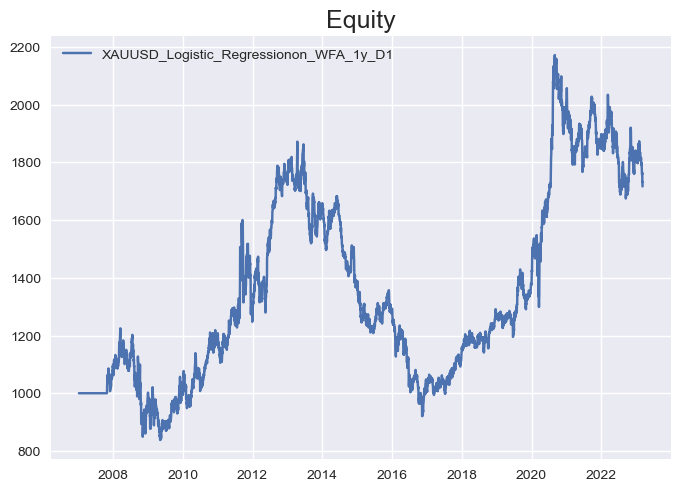

In [45]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [46]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [47]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [48]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [49]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [50]:
test = ml.Run()

In [51]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                     89.9722
Equity Final [$]                     1827.269
Equity Peak [$]                      1966.676
Return [%]                            82.7269
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    3.062464
Volatility (Ann.) [%]               15.022051
Sharpe Ratio                         0.203865
Sortino Ratio                        0.304397
Calmar Ratio                         0.066374
Max. Drawdown [%]                  -46.139194
Avg. Drawdown [%]                   -5.254516
Max. Drawdown Duration     2664 days 00:00:00
Avg. Drawdown Duration      147 days 00:00:00
# Trades                                 1343
Win Rate [%]                        52.419955
Best Trade [%]                      10.279385
Worst Trade [%]                    -12.434624
Avg. Trade [%]                    

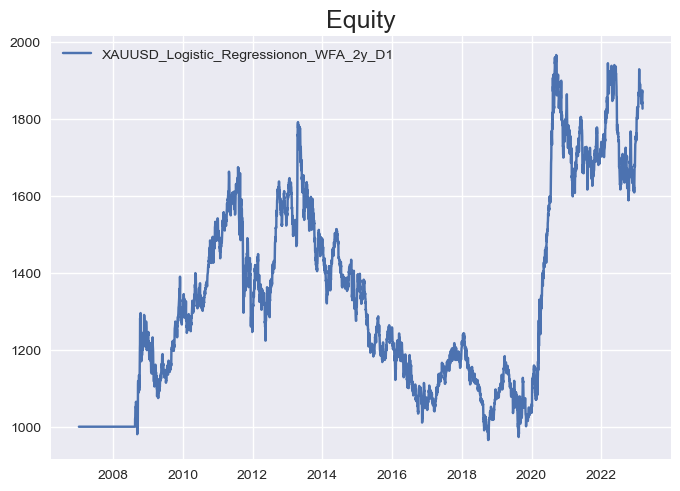

In [52]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [53]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [54]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [55]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [56]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [57]:
test = ml.Run()

In [58]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   84.968229
Equity Final [$]                     2055.784
Equity Peak [$]                      2503.013
Return [%]                           105.5784
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    3.671959
Volatility (Ann.) [%]               11.532408
Sharpe Ratio                         0.318403
Sortino Ratio                        0.476151
Calmar Ratio                         0.161514
Max. Drawdown [%]                   -22.73464
Avg. Drawdown [%]                   -3.000969
Max. Drawdown Duration     1636 days 00:00:00
Avg. Drawdown Duration       77 days 00:00:00
# Trades                                 1075
Win Rate [%]                        53.116279
Best Trade [%]                       17.74495
Worst Trade [%]                    -13.796925
Avg. Trade [%]                    

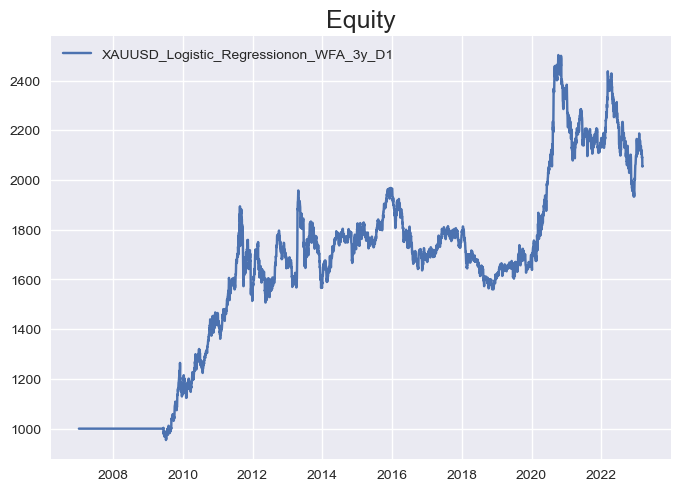

In [59]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [60]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [61]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [62]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [63]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [64]:
test = ml.Run()

In [65]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   79.964257
Equity Final [$]                     2354.866
Equity Peak [$]                      2561.959
Return [%]                           135.4866
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    4.378988
Volatility (Ann.) [%]               12.619026
Sharpe Ratio                         0.347015
Sortino Ratio                        0.510606
Calmar Ratio                         0.126762
Max. Drawdown [%]                  -34.545006
Avg. Drawdown [%]                   -2.952747
Max. Drawdown Duration     3257 days 00:00:00
Avg. Drawdown Duration       99 days 00:00:00
# Trades                                  997
Win Rate [%]                        53.560682
Best Trade [%]                       46.42927
Worst Trade [%]                     -7.732588
Avg. Trade [%]                    

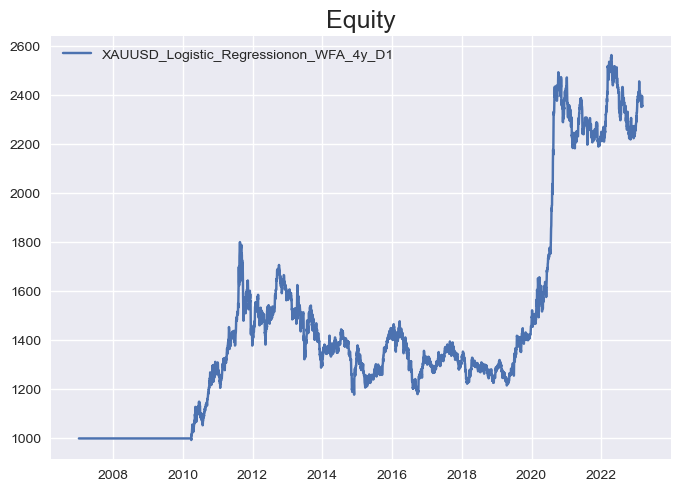

In [66]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [67]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [68]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [69]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [70]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [71]:
test = ml.Run()

In [72]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   74.960286
Equity Final [$]                      462.742
Equity Peak [$]                      1548.247
Return [%]                           -53.7258
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                   -3.782592
Volatility (Ann.) [%]               39.968637
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -88.441121
Avg. Drawdown [%]                   -7.256819
Max. Drawdown Duration     4217 days 00:00:00
Avg. Drawdown Duration      259 days 00:00:00
# Trades                                  961
Win Rate [%]                         51.82102
Best Trade [%]                      18.997069
Worst Trade [%]                    -11.853532
Avg. Trade [%]                    

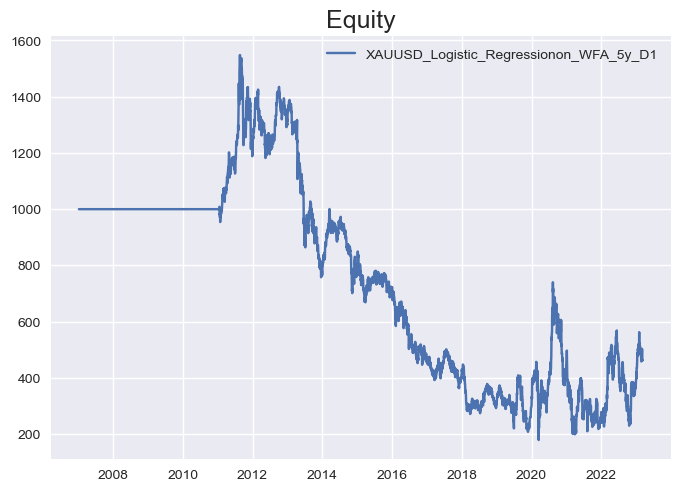

In [73]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [74]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [75]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [76]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [77]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [78]:
test = ml.Run()

In [79]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   23.113582
Equity Final [$]                        8.025
Equity Peak [$]                      1020.036
Return [%]                           -99.1975
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                  -21.451295
Volatility (Ann.) [%]               49.064051
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -99.50737
Avg. Drawdown [%]                  -22.060702
Max. Drawdown Duration     3808 days 00:00:00
Avg. Drawdown Duration      690 days 00:00:00
# Trades                                  151
Win Rate [%]                        48.344371
Best Trade [%]                       4.362906
Worst Trade [%]                    -15.245244
Avg. Trade [%]                    

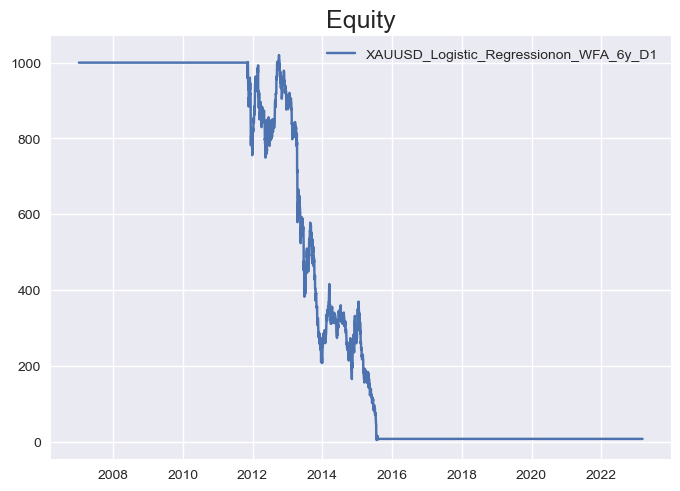

In [80]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [81]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [82]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [83]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [84]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [85]:
test = ml.Run()

In [86]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   34.273233
Equity Final [$]                          0.0
Equity Peak [$]                      1137.327
Return [%]                             -100.0
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]               69.742328
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -14.885906
Max. Drawdown Duration     3808 days 00:00:00
Avg. Drawdown Duration      548 days 00:00:00
# Trades                                  470
Win Rate [%]                        48.297872
Best Trade [%]                       3.469853
Worst Trade [%]                    -11.478504
Avg. Trade [%]                    

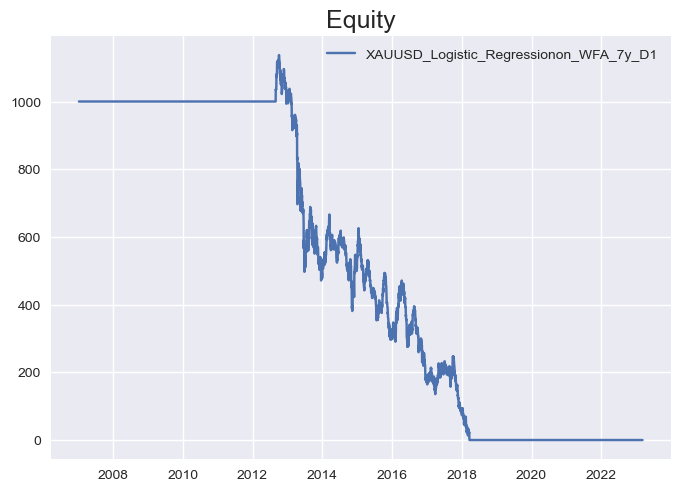

In [87]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [88]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [89]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [90]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [91]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [92]:
test = ml.Run()

In [93]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   59.948372
Equity Final [$]                      675.364
Equity Peak [$]                      1104.715
Return [%]                           -32.4636
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                   -1.944914
Volatility (Ann.) [%]               21.074892
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -57.909597
Avg. Drawdown [%]                  -14.927114
Max. Drawdown Duration     3481 days 00:00:00
Avg. Drawdown Duration      709 days 00:00:00
# Trades                                  879
Win Rate [%]                        53.469852
Best Trade [%]                       7.698643
Worst Trade [%]                      -8.08233
Avg. Trade [%]                    

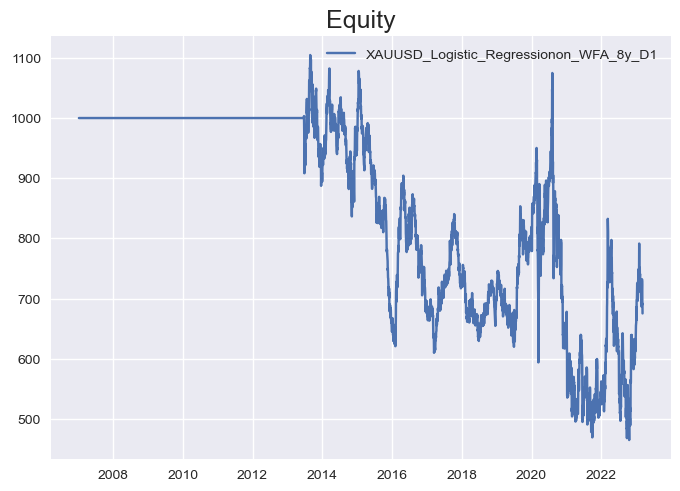

In [94]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [95]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [96]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [14]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H4'

### Window size 1 year

In [13]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [14]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [15]:
test = ml.Run()

In [16]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   94.173823
Equity Final [$]                    11690.489
Equity Peak [$]                     12152.195
Return [%]                           16.90489
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    0.783698
Volatility (Ann.) [%]                1.769661
Sharpe Ratio                         0.442852
Sortino Ratio                        0.626024
Calmar Ratio                           0.1435
Max. Drawdown [%]                    -5.46131
Avg. Drawdown [%]                   -0.175109
Max. Drawdown Duration     2642 days 00:00:00
Avg. Drawdown Duration       20 days 10:00:00
# Trades                                 8648
Win Rate [%]                        55.966698
Best Trade [%]                       6.728522
Worst Trade [%]                     -7.427126
Avg. Trade [%]                    

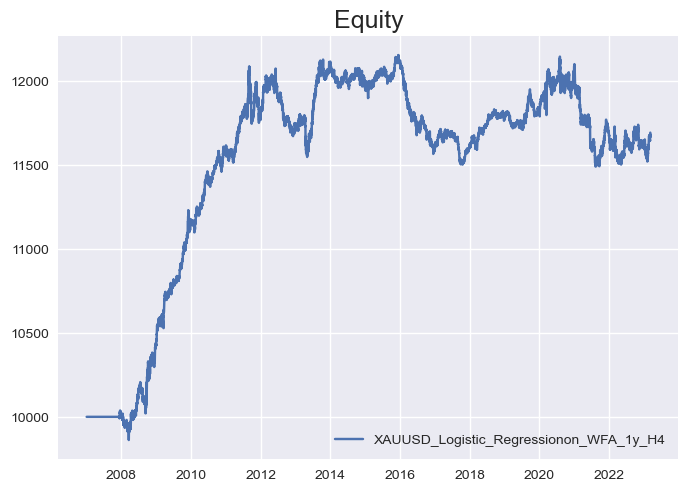

In [17]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [18]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [19]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [20]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [21]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [22]:
test = ml.Run()

In [23]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   88.351496
Equity Final [$]                     12019.91
Equity Peak [$]                     12301.295
Return [%]                            20.1991
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    0.923773
Volatility (Ann.) [%]                1.660125
Sharpe Ratio                         0.556448
Sortino Ratio                        0.779272
Calmar Ratio                         0.205356
Max. Drawdown [%]                   -4.498386
Avg. Drawdown [%]                   -0.179027
Max. Drawdown Duration      895 days 16:00:00
Avg. Drawdown Duration       16 days 07:00:00
# Trades                                 7655
Win Rate [%]                        58.184193
Best Trade [%]                       3.569305
Worst Trade [%]                     -6.483905
Avg. Trade [%]                    

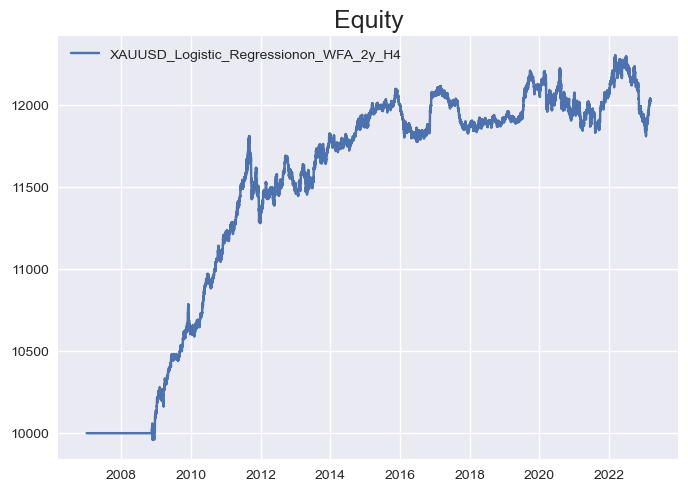

In [24]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [25]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [26]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [27]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [28]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [29]:
test = ml.Run()

In [30]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   82.529169
Equity Final [$]                    10435.335
Equity Peak [$]                     11405.008
Return [%]                            4.35335
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    0.213205
Volatility (Ann.) [%]                1.748616
Sharpe Ratio                         0.121928
Sortino Ratio                        0.164503
Calmar Ratio                         0.022604
Max. Drawdown [%]                   -9.432199
Avg. Drawdown [%]                   -0.201647
Max. Drawdown Duration     2199 days 00:00:00
Avg. Drawdown Duration       26 days 09:00:00
# Trades                                 6588
Win Rate [%]                        58.287796
Best Trade [%]                       3.569305
Worst Trade [%]                      -8.06782
Avg. Trade [%]                    

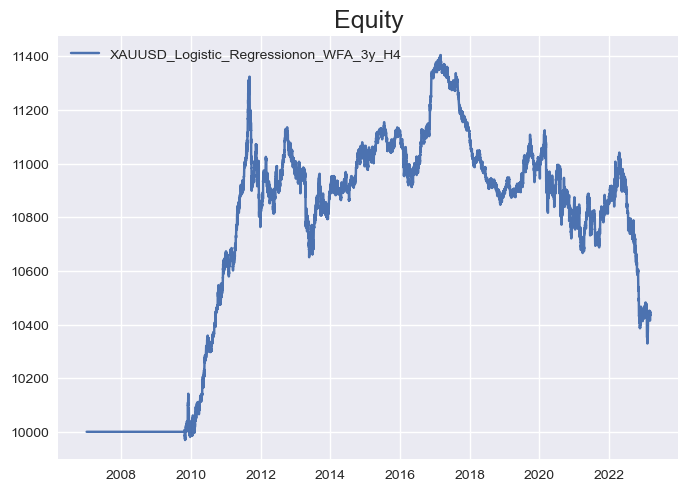

In [31]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [32]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [33]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [34]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [35]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [36]:
test = ml.Run()

In [37]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   76.706843
Equity Final [$]                    10032.047
Equity Peak [$]                     10837.384
Return [%]                            0.32047
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    0.015993
Volatility (Ann.) [%]                1.756684
Sharpe Ratio                         0.009104
Sortino Ratio                        0.012285
Calmar Ratio                         0.002152
Max. Drawdown [%]                   -7.431101
Avg. Drawdown [%]                   -0.214489
Max. Drawdown Duration     4207 days 08:00:00
Avg. Drawdown Duration       47 days 14:00:00
# Trades                                 5738
Win Rate [%]                        59.550366
Best Trade [%]                        4.66669
Worst Trade [%]                      -8.06782
Avg. Trade [%]                    

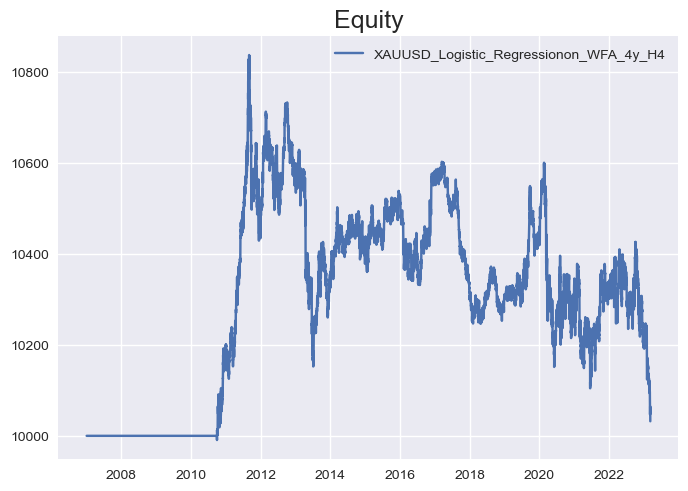

In [38]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [39]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [40]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [41]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [42]:
ml = ML_Regression(data, strategy, start_train,
                   end_train, TF, window_size, 500)

In [43]:
test = ml.Run()

In [44]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   10.531788
Equity Final [$]                          0.0
Equity Peak [$]                       543.619
Return [%]                             -100.0
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                 71.2802
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -53.76204
Max. Drawdown Duration     3824 days 08:00:00
Avg. Drawdown Duration     1401 days 04:00:00
# Trades                                  528
Win Rate [%]                        53.977273
Best Trade [%]                       3.253319
Worst Trade [%]                     -6.474293
Avg. Trade [%]                    

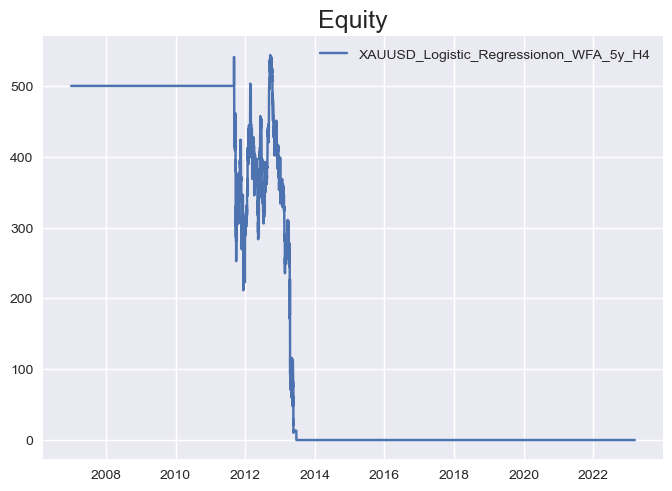

In [45]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [46]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [47]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [48]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [49]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [50]:
test = ml.Run()

In [51]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                    65.06219
Equity Final [$]                     9026.091
Equity Peak [$]                     10142.936
Return [%]                           -9.73909
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                   -0.510816
Volatility (Ann.) [%]                1.716071
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -11.530626
Avg. Drawdown [%]                   -0.667662
Max. Drawdown Duration     3808 days 12:00:00
Avg. Drawdown Duration      192 days 19:00:00
# Trades                                 4804
Win Rate [%]                        60.241465
Best Trade [%]                       3.380317
Worst Trade [%]                      -8.06782
Avg. Trade [%]                    

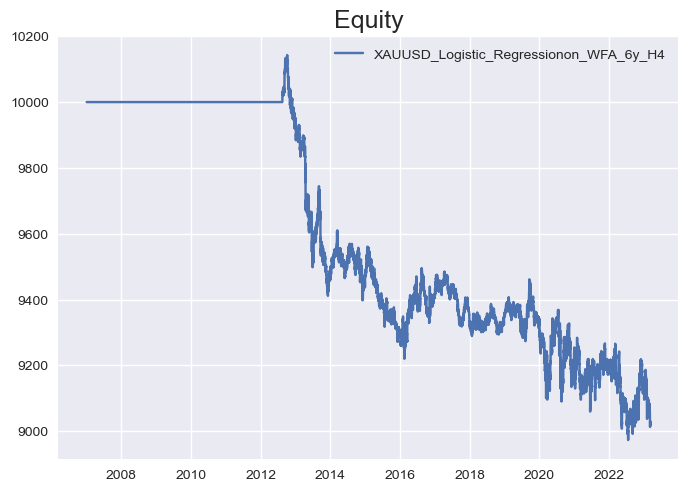

In [52]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [53]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [54]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [55]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [56]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [57]:
test = ml.Run()

In [58]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   59.239863
Equity Final [$]                    10133.331
Equity Peak [$]                     10347.723
Return [%]                            1.33331
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    0.066221
Volatility (Ann.) [%]                1.526363
Sharpe Ratio                         0.043385
Sortino Ratio                        0.058694
Calmar Ratio                         0.016777
Max. Drawdown [%]                   -3.947023
Avg. Drawdown [%]                   -0.302788
Max. Drawdown Duration     2039 days 20:00:00
Avg. Drawdown Duration       77 days 20:00:00
# Trades                                 4638
Win Rate [%]                         62.07417
Best Trade [%]                       2.992002
Worst Trade [%]                     -7.233754
Avg. Trade [%]                    

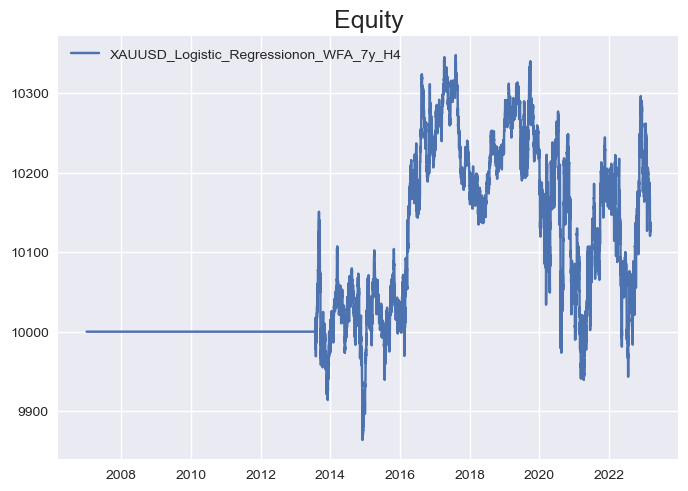

In [59]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [60]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [61]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [15]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [16]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [17]:
test = ml.Run()

In [18]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   53.417536
Equity Final [$]                     9726.541
Equity Peak [$]                     10244.068
Return [%]                           -2.73459
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                   -0.138483
Volatility (Ann.) [%]                1.478651
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -5.574563
Avg. Drawdown [%]                   -0.414564
Max. Drawdown Duration     1394 days 04:00:00
Avg. Drawdown Duration       80 days 22:00:00
# Trades                                 4278
Win Rate [%]                        61.921459
Best Trade [%]                       2.641672
Worst Trade [%]                     -7.233754
Avg. Trade [%]                    

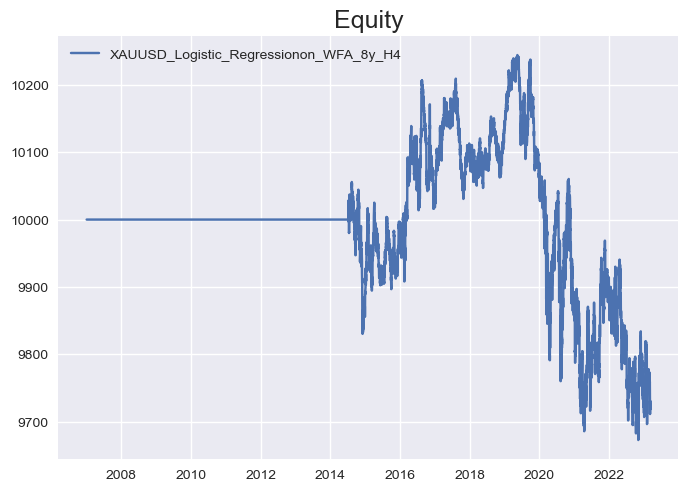

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [20]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [21]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [11]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H1'

### Window size 1 year

In [12]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [13]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [14]:
test = ml.Run()

In [15]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   93.824211
Equity Final [$]                    12218.954
Equity Peak [$]                     12512.105
Return [%]                           22.18954
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    1.006451
Volatility (Ann.) [%]                1.751433
Sharpe Ratio                         0.574644
Sortino Ratio                        0.813457
Calmar Ratio                         0.214927
Max. Drawdown [%]                   -4.682761
Avg. Drawdown [%]                   -0.100811
Max. Drawdown Duration     1519 days 04:00:00
Avg. Drawdown Duration        7 days 12:00:00
# Trades                                32818
Win Rate [%]                        61.216406
Best Trade [%]                       3.364166
Worst Trade [%]                     -8.781733
Avg. Trade [%]                    

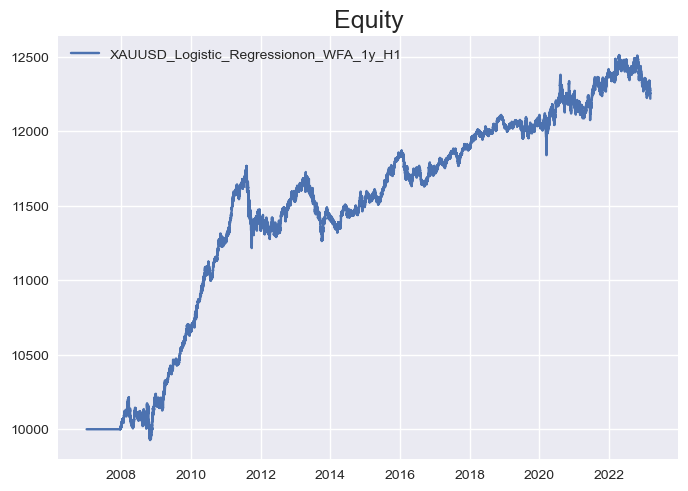

In [16]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [17]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [18]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [19]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [20]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [21]:
test = ml.Run()

In [22]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   87.649443
Equity Final [$]                    13165.269
Equity Peak [$]                     13347.454
Return [%]                           31.65269
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    1.383653
Volatility (Ann.) [%]                1.587143
Sharpe Ratio                         0.871788
Sortino Ratio                        1.260595
Calmar Ratio                         0.295185
Max. Drawdown [%]                   -4.687407
Avg. Drawdown [%]                   -0.099696
Max. Drawdown Duration      982 days 22:00:00
Avg. Drawdown Duration        5 days 18:00:00
# Trades                                28869
Win Rate [%]                        62.347154
Best Trade [%]                       3.364166
Worst Trade [%]                     -5.239903
Avg. Trade [%]                    

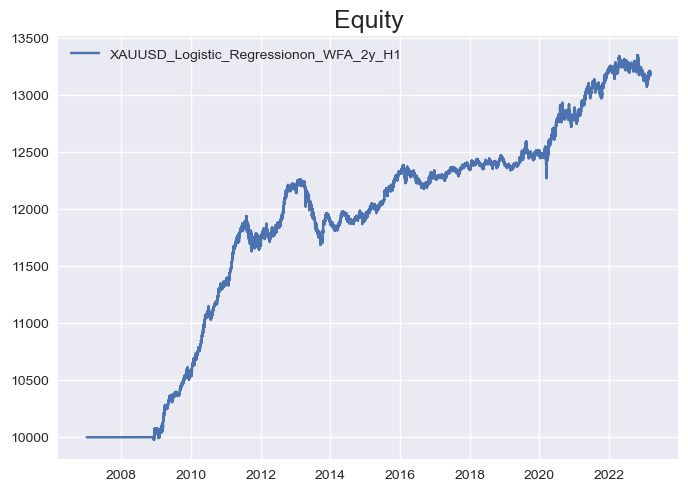

In [23]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [24]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [25]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   81.474675
Equity Final [$]                     2603.657
Equity Peak [$]                       2704.48
Return [%]                           160.3657
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    4.897908
Volatility (Ann.) [%]               11.207171
Sharpe Ratio                         0.437033
Sortino Ratio                        0.652963
Calmar Ratio                         0.191909
Max. Drawdown [%]                  -25.521974
Avg. Drawdown [%]                   -0.895694
Max. Drawdown Duration     1303 days 04:00:00
Avg. Drawdown Duration       13 days 07:00:00
# Trades                                19828
Win Rate [%]                        54.120436
Best Trade [%]                       3.223874
Worst Trade [%]                     -7.328009
Avg. Trade [%]                    

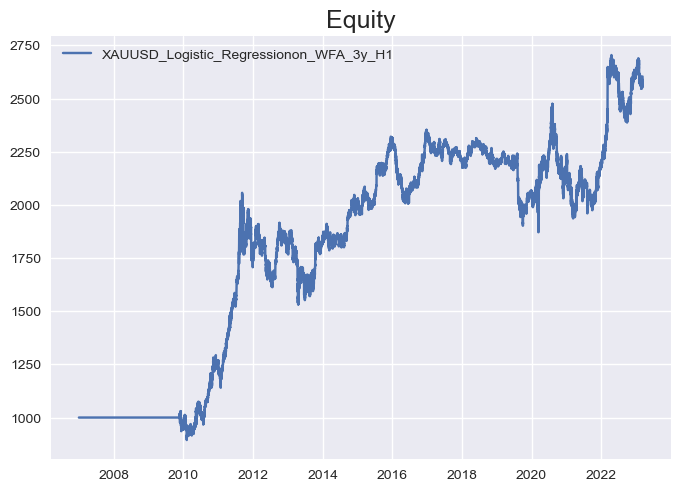

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [26]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [27]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [28]:
test = ml.Run()

In [29]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   75.299907
Equity Final [$]                    12438.071
Equity Peak [$]                     12504.794
Return [%]                           24.38071
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                      1.0962
Volatility (Ann.) [%]                1.642797
Sharpe Ratio                         0.667277
Sortino Ratio                        0.939205
Calmar Ratio                         0.156511
Max. Drawdown [%]                   -7.003996
Avg. Drawdown [%]                    -0.09642
Max. Drawdown Duration     1542 days 01:00:00
Avg. Drawdown Duration        6 days 23:00:00
# Trades                                25242
Win Rate [%]                        63.814278
Best Trade [%]                       3.292779
Worst Trade [%]                     -5.153479
Avg. Trade [%]                    

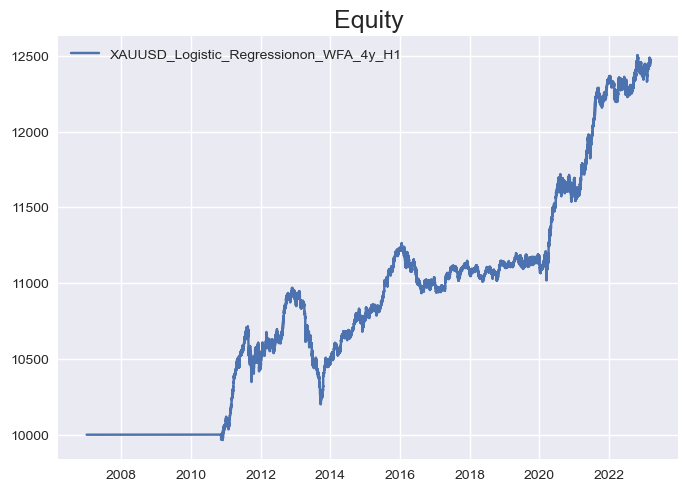

In [30]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [31]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [32]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [ ]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'M30'

### Window size 1 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48
WFA = '7y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')